In [125]:
using Pkg

In [126]:
Pkg.activate(dirname(pwd()))

  Activating environment at `~/Documents/GitHub/ComputationalHeatTransfer.jl/Project.toml`


In [127]:
using ComputationalHeatTransfer
using Plots
gr()  
using XLSX

In [411]:
using SparseArrays

In [422]:
function getboilhist(sysfinal,tend,boil_dt)
    boil_matrix=spzeros(size(sysfinal[end].wall.Xstations,1),Int64(round(tend/boil_dt)));
    for tnum = 1:size(boil_matrix,2)
         boil_index = findall(x->Int64(round(x/boil_dt))==tnum,boil_data[:,2])

        if length(boil_index) != 0
            i_station_temp = Int64.(boil_data[boil_index,1])
            for i in i_station_temp
                boil_matrix[i,tnum] = 1
            end
        end
    end
    
    boil_num_t = sum(boil_matrix, dims=1)'
    boil_num_x = sum(boil_matrix, dims=2);
    
    boil_num_t,boil_num_x
end

getboilhist (generic function with 1 method)

## Get fluid properties

In [128]:
fluid_type = "butane"
Tᵥ = 291.2

291.2

In [129]:
using UnPack

p_fluid = get_saturation_property(fluid_type,Tᵥ)
@unpack Cpₗ,ρₗ,μₗ,hₗ,kₗ,Prₗ,Cpᵥ,ρᵥ,μᵥ,hᵥ,kᵥ,Prᵥ,σ,P,R,M,Rkg,αₗ,νₗ,νᵥ,hₗᵥ = p_fluid;

## Read data

In [130]:
using JLD2

In [438]:
# OHPdata1 = load(dirname(pwd())*"/src/OHP1_10W_E065_2_DT1.jld2");
OHPdata1 = load(dirname(pwd())*"/notebooks/OHP1_10W_E065_2_DT1.jld2");
OHPdata2 = load(dirname(pwd())*"/src/OHP1_20W_E065_2_DT1.jld2");
OHPdata3 = load(dirname(pwd())*"/src/OHP1_30W_E065_2_DT1.jld2");
OHPdata4 = load(dirname(pwd())*"/src/OHP1_40W_E065_2_DT1.jld2");
OHPdata1s = load(dirname(pwd())*"/notebooks/OHP1_10W_E065_2_DT1_small.jld2");

┌ Warning: read type ODEFunction{false,Main.#ODE_innertube,LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing} has a different number of parameters from type ODEFunction in workspace; reconstructing
└ @ JLD2 /Users/yuxuanli/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:423
┌ Warning: some parameters could not be resolved for type DiscreteCallback{Main.#fixdx_condition,Main.#fixdx_affect!,typeof(SciMLBase.INITIALIZE_DEFAULT),typeof(SciMLBase.FINALIZE_DEFAULT)}; reconstructing
└ @ JLD2 /Users/yuxuanli/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:451
┌ Warning: some parameters could not be resolved for type DiscreteCallback{Main.#boiling_condition,Main.#boiling_affect!,typeof(SciMLBase.INITIALIZE_DEFAULT),typeof(SciMLBase.FINALIZE_DEFAULT)}; reconstructing
└ @ JLD2 /Users/yuxuanli/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_

┌ Warning: read type ODEFunction{false,Main.#ODE_innertube,LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing} has a different number of parameters from type ODEFunction in workspace; reconstructing
└ @ JLD2 /Users/yuxuanli/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:423
┌ Warning: some parameters could not be resolved for type DiscreteCallback{Main.#fixdx_condition,Main.#fixdx_affect!,typeof(SciMLBase.INITIALIZE_DEFAULT),typeof(SciMLBase.FINALIZE_DEFAULT)}; reconstructing
└ @ JLD2 /Users/yuxuanli/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:451
┌ Warning: some parameters could not be resolved for type DiscreteCallback{Main.#boiling_condition,Main.#boiling_affect!,typeof(SciMLBase.INITIALIZE_DEFAULT),typeof(SciMLBase.FINALIZE_DEFAULT)}; reconstructing
└ @ JLD2 /Users/yuxuanli/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_

┌ Warning: read type ODEFunction{false,Main.#ODE_innertube,LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing} has a different number of parameters from type ODEFunction in workspace; reconstructing
└ @ JLD2 /Users/yuxuanli/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:423
┌ Warning: some parameters could not be resolved for type DiscreteCallback{Main.#fixdx_condition,Main.#fixdx_affect!,typeof(SciMLBase.INITIALIZE_DEFAULT),typeof(SciMLBase.FINALIZE_DEFAULT)}; reconstructing
└ @ JLD2 /Users/yuxuanli/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:451
┌ Warning: some parameters could not be resolved for type DiscreteCallback{Main.#boiling_condition,Main.#boiling_affect!,typeof(SciMLBase.INITIALIZE_DEFAULT),typeof(SciMLBase.FINALIZE_DEFAULT)}; reconstructing
└ @ JLD2 /Users/yuxuanli/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_

In [184]:
# OHPdata1 = load(dirname(pwd())*"/src/OHP1_10W_E063_2_DT1_small.jld2");
# OHPdata2 = load(dirname(pwd())*"/src/OHP1_20W_E063_2_DT1_small.jld2");
# OHPdata3 = load(dirname(pwd())*"/src/OHP1_30W_E063_2_DT1_small.jld2");
# OHPdata4 = load(dirname(pwd())*"/src/OHP1_40W_E063_2_DT1_small.jld2");

In [388]:
OHPdata = OHPdata1
power = 10

10

In [336]:
OHPdata = OHPdata2
power = 20

20

In [349]:
OHPdata = OHPdata3
power = 30

30

In [359]:
OHPdata = OHPdata4
power = 40

40

In [439]:
OHPdata = OHPdata1s
power = 10

10

## Dryness

In [440]:
boil_data = OHPdata["boil_data"]
tube_hist = OHPdata["tube_hist"]
sysfinal = getsysfinal(tube_hist);

plate_T_hist = OHPdata["plate_T_hist"]

integrator_plate = OHPdata["integrator_plate"]
sys = integrator_plate.p

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


## Get RTD result for OHP

In [441]:
# filepath = "20190612_F_PD_%23003_O001_H001_P030_expA.xlsx"
# xf = XLSX.readxlsx(dirname(pwd())*"/expdata/"*filepath)

# Onum, Hnum, power = getconfig(filepath)
# RTD,RTDt = getRTD(xf,Onum);

## set probe coordinates

In [442]:
const inch = 2.54e-2;

x = [-2.75inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];
X =  VectorData(x,y);

## get interpolation operator

In [443]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

## get temperature curve time series

In [444]:
ghist,thist = getgt(g,H,plate_T_hist,tube_hist);

## wettedness

In [445]:
wetness = getwetness(sysfinal); 
Vabs_avg,Vavg,Vabs_max = getV(sysfinal);
δ_avg_start,δ_avg_end = getδ(sysfinal);

In [446]:
Vabs_avg,Vavg,Vabs_max = getV(sysfinal);

In [447]:
δ_avg_start,δ_avg_end = getδ(sysfinal);

## thermal conductance

In [448]:
# power = 10
i1 = 4 #RTD number
i2 = 8 #RTD number


8

## convert data

In [397]:
wetness_10W = getwetness(sysfinal);
Vabs_avg_10W,Vavg_10W,Vabs_max_10W = getV(sysfinal);
δ_avg_start_10W,δ_avg_end_10W = getδ(sysfinal);
conductance_10W = power ./ (ghist[i1] .-ghist[i2]);
thist_10W = thist;
ghist_10W = ghist;

In [345]:
wetness_20W = getwetness(sysfinal);
Vabs_avg_20W,Vavg_20W,Vabs_max_20W = getV(sysfinal);
δ_avg_start_20W,δ_avg_end_20W = getδ(sysfinal);
conductance_20W = power ./ (ghist[i1] .-ghist[i2]);
thist_20W = thist;
ghist_20W = ghist;

In [358]:
wetness_30W = getwetness(sysfinal);
Vabs_avg_30W,Vavg_30W,Vabs_max_30W = getV(sysfinal);
δ_avg_start_30W,δ_avg_end_30W = getδ(sysfinal);
conductance_30W = power ./ (ghist[i1] .-ghist[i2]);
thist_30W = thist;
ghist_30W = ghist;

In [368]:
wetness_40W = getwetness(sysfinal);
Vabs_avg_40W,Vavg_40W,Vabs_max_40W = getV(sysfinal);
δ_avg_start_40W,δ_avg_end_40W = getδ(sysfinal);
conductance_40W = power ./ (ghist[i1] .-ghist[i2]);
thist_40W = thist;
ghist_40W = ghist;

In [450]:
wetness_10Ws = getwetness(sysfinal);
Vabs_avg_10Ws,Vavg_10Ws,Vabs_max_10Ws = getV(sysfinal);
δ_avg_start_10Ws,δ_avg_end_10Ws = getδ(sysfinal);
conductance_10Ws = power ./ (ghist[i1] .-ghist[i2]);
thist_10Ws = thist;
ghist_10Ws = ghist;

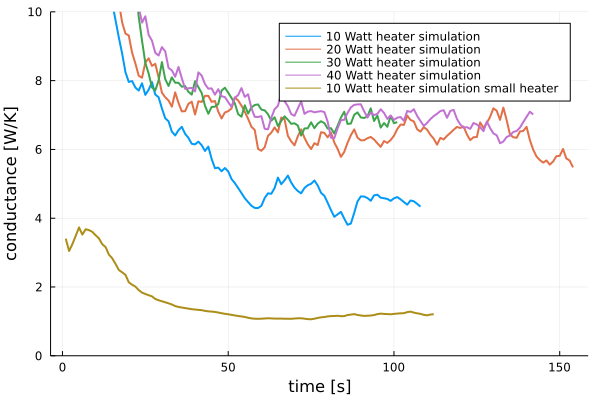

In [451]:
plot(conductance_10W ,label=string(10)*" Watt heater simulation",linewidth=2,ylim=(0,10),xlabel="time [s]", ylabel="conductance [W/K]")
plot!(conductance_20W ,label=string(20)*" Watt heater simulation",linewidth=2,ylim=(0,10),xlabel="time [s]", ylabel="conductance [W/K]")
plot!(conductance_30W ,label=string(30)*" Watt heater simulation",linewidth=2,ylim=(0,10),xlabel="time [s]", ylabel="conductance [W/K]")
plot!(conductance_40W ,label=string(40)*" Watt heater simulation",linewidth=2,ylim=(0,10),xlabel="time [s]", ylabel="conductance [W/K]")
plot!(conductance_10Ws ,label=string(10)*" Watt heater simulation small heater",linewidth=2,ylim=(0,10),xlabel="time [s]", ylabel="conductance [W/K]")

In [370]:
# plot(thist,conductance ,label=string(power)*" Watt heater simulation",linewidth=2,ylim=(0,10),xlabel="time [s]", ylabel="conductance [W/K]")

## Wettedness

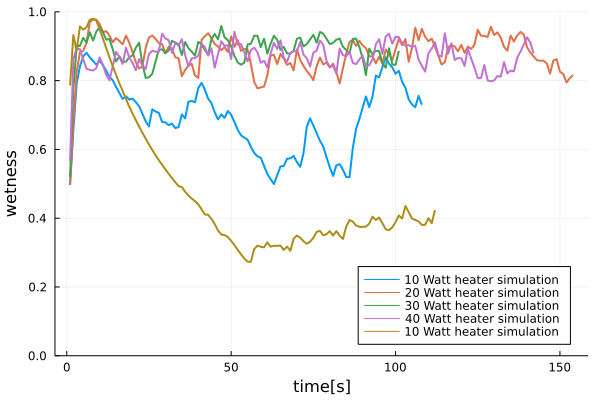

In [471]:
plot(wetness_10W ,label=string(10)*" Watt heater simulation",linewidth=2,ylim=(0,1))
plot!(wetness_20W ,label=string(20)*" Watt heater simulation",linewidth=2,ylim=(0,1))
plot!(wetness_30W ,label=string(30)*" Watt heater simulation",linewidth=2,ylim=(0,1))
plot!(wetness_40W ,label=string(40)*" Watt heater simulation",linewidth=2,ylim=(0,1),legend=:bottomright)
plot!(wetness_10Ws ,label=string(10)*" Watt heater simulation",linewidth=2,ylim=(0,1),ylabel="wetness",xlabel="time[s]")

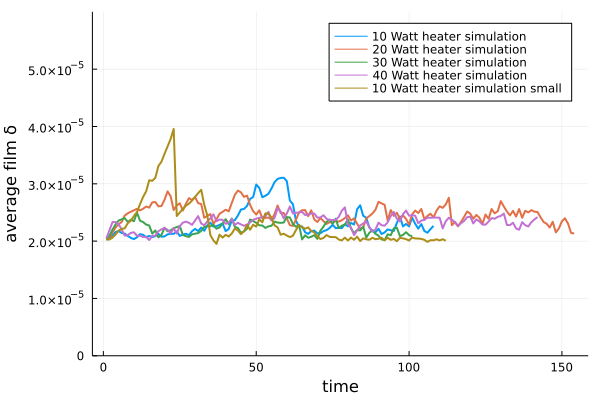

In [472]:
plot(mean([δ_avg_start_10W,δ_avg_end_10W]) ,label=string(10)*" Watt heater simulation",linewidth=2,ylim=(0,6e-5))
plot!(mean([δ_avg_start_20W,δ_avg_end_20W]) ,label=string(20)*" Watt heater simulation",linewidth=2,ylim=(0,6e-5))
plot!(mean([δ_avg_start_30W,δ_avg_end_30W]) ,label=string(30)*" Watt heater simulation",linewidth=2,ylim=(0,6e-5))
plot!(mean([δ_avg_start_40W,δ_avg_end_40W]) ,label=string(40)*" Watt heater simulation",linewidth=2,ylim=(0,6e-5))
plot!(mean([δ_avg_start_10Ws,δ_avg_end_10Ws]) ,label=string(10)*" Watt heater simulation small",linewidth=2,ylim=(0,6e-5),ylabel="average film δ",xlabel="time")

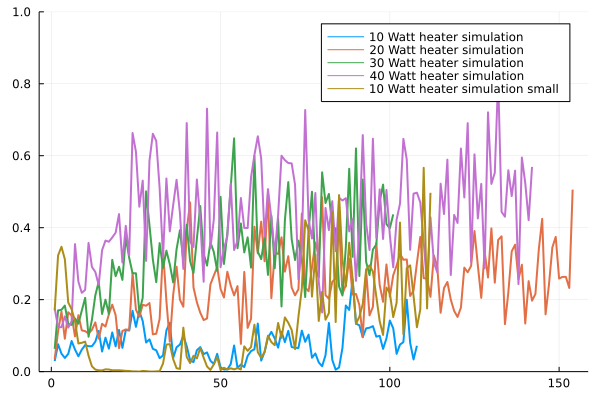

In [467]:
plot(Vabs_avg_10W,label=string(10)*" Watt heater simulation",linewidth=2,ylim=(0,6e-5))
plot!(Vabs_avg_20W,label=string(20)*" Watt heater simulation",linewidth=2,ylim=(0,6e-5))
plot!(Vabs_avg_30W,label=string(30)*" Watt heater simulation",linewidth=2,ylim=(0,6e-5))
plot!(Vabs_avg_40W,label=string(40)*" Watt heater simulation",linewidth=2,ylim=(0,6e-5))
plot!(Vabs_avg_10Ws,label=string(10)*" Watt heater simulation small",linewidth=2,ylim=(0,1),ylabel="average speed of liquid slug")

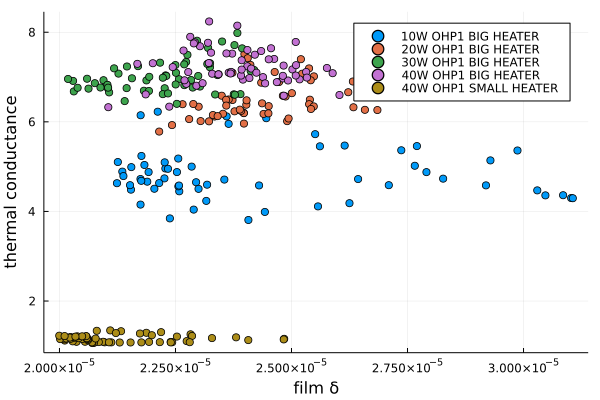

In [473]:
# scatter(Vabs_max,wetness,ylim=(0.5,1),xlim=(0,1.5))
scatter(mean([δ_avg_start_10W,δ_avg_end_10W])[40:100],conductance_10W[40:end],label="10W OHP1 BIG HEATER")
scatter!(mean([δ_avg_start_20W,δ_avg_end_20W])[40:100],conductance_20W[40:100],label="20W OHP1 BIG HEATER")
scatter!(mean([δ_avg_start_30W,δ_avg_end_30W])[40:100],conductance_30W[40:100],label="30W OHP1 BIG HEATER")
scatter!(mean([δ_avg_start_40W,δ_avg_end_40W])[40:100],conductance_40W[40:100],label="40W OHP1 BIG HEATER",legend=:topright)
scatter!(mean([δ_avg_start_10Ws,δ_avg_end_10Ws])[40:100],conductance_10Ws[40:100],label="40W OHP1 SMALL HEATER",legend=:topright,ylabel="thermal conductance",xlabel="film δ")

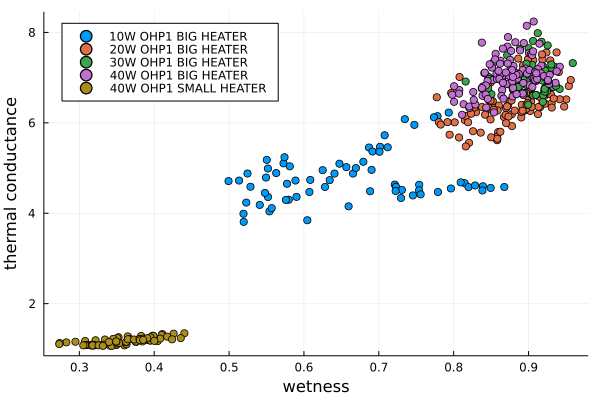

In [475]:
# scatter(Vabs_max,wetness,ylim=(0.5,1),xlim=(0,1.5))
scatter(wetness_10W[40:end],conductance_10W[40:end],label="10W OHP1 BIG HEATER")
scatter!(wetness_20W[40:end],conductance_20W[40:end],label="20W OHP1 BIG HEATER")
scatter!(wetness_30W[40:end],conductance_30W[40:end],label="30W OHP1 BIG HEATER")
scatter!(wetness_40W[40:end],conductance_40W[40:end],label="40W OHP1 BIG HEATER",legend=:topleft)
scatter!(wetness_10Ws[40:end],conductance_10Ws[40:end],label="40W OHP1 SMALL HEATER",legend=:topleft,ylabel="thermal conductance",xlabel="wetness")

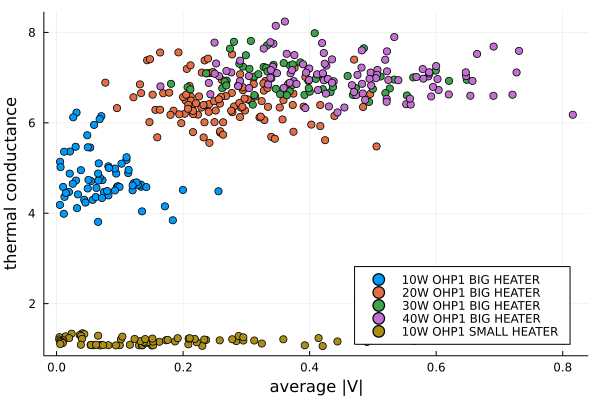

In [478]:
# scatter(Vabs_max,wetness,ylim=(0.5,1),xlim=(0,1.5))
scatter(Vabs_avg_10W[40:end],conductance_10W[40:end],label="10W OHP1 BIG HEATER")
scatter!(Vabs_avg_20W[40:end],conductance_20W[40:end],label="20W OHP1 BIG HEATER")
scatter!(Vabs_avg_30W[40:end],conductance_30W[40:end],label="30W OHP1 BIG HEATER")
scatter!(Vabs_avg_40W[40:end],conductance_40W[40:end],label="40W OHP1 BIG HEATER",legend=:topleft)
scatter!(Vabs_avg_10Ws[40:end],conductance_10Ws[40:end],label="10W OHP1 SMALL HEATER",legend=:bottomright,ylabel="thermal conductance",xlabel="average |V|")

In [424]:
tend = round(tube_hist[end].t)
boil_dt = 0.1
boil_num_t,boil_num_x = getboilhist(sysfinal,tend,boil_dt);

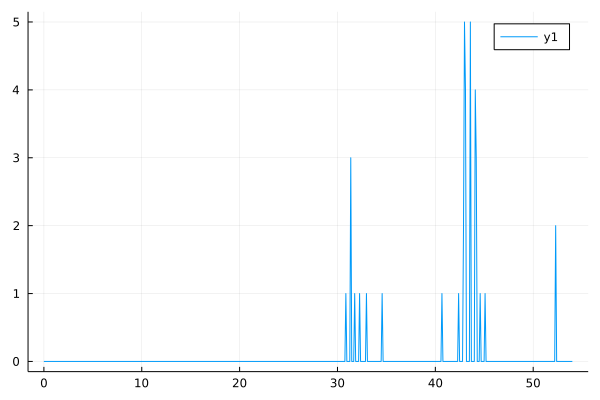

In [437]:
plot(range(0,stop=tend,length=length(boil_num_t)),boil_num_t)

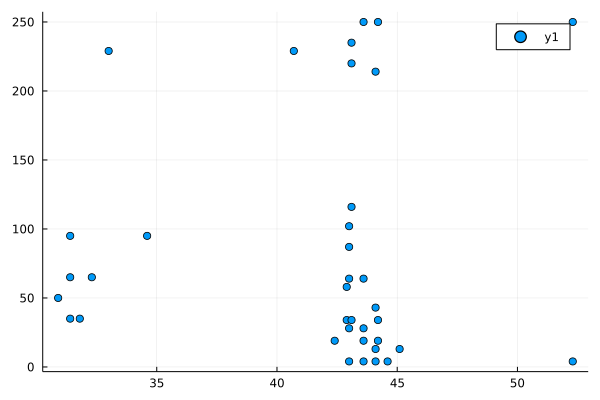

In [420]:
scatter(boil_data[:,2],boil_data[:,1])

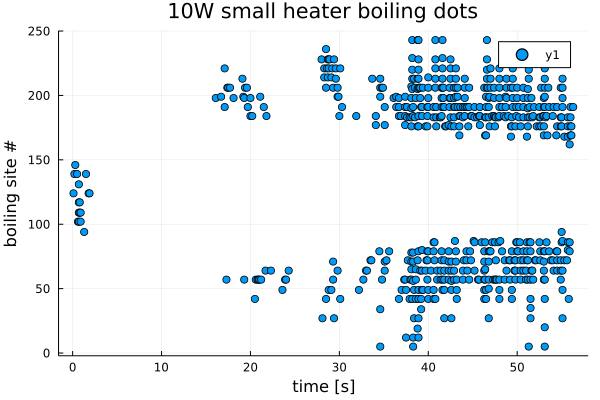

In [462]:
scatter(boil_data[:,2],boil_data[:,1],title="10W small heater boiling dots",xlabel="time [s]",ylabel="boiling site #")